In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Fraud Analytics/Payments.csv')
# print(df.columns)

df = df.groupby(['Sender','Receiver'],as_index = False)['Amount'].sum()

In [ ]:
import networkx as nx

G=nx.DiGraph()

for index,row in df.iterrows():
  G.add_edge(row['Sender'],row['Receiver'],weight=row['Amount'])

num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f'Number of nodes: {num_nodes}')
print(f'Number of edges: {num_edges}')
print(f'Ratio edges to nodes: {round(num_edges / num_nodes, 2)}')

Number of nodes: 799
Number of edges: 5358
Ratio edges to nodes: 6.71


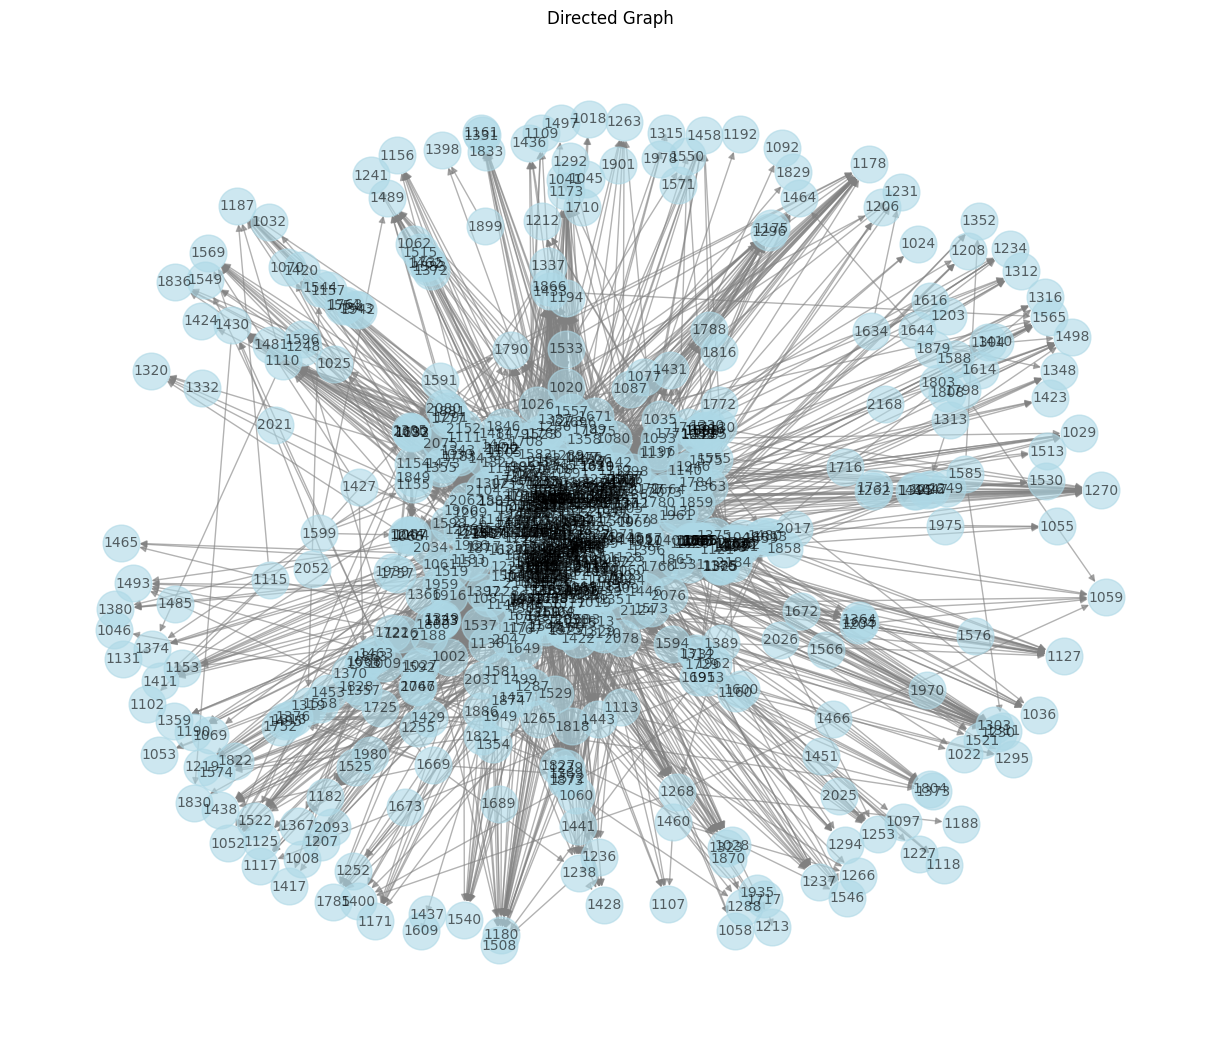

In [ ]:
# Visualize the directed graph
pos = nx.spring_layout(G, seed=42, k=0.9)
labels = nx.get_edge_attributes(G, 'label')
plt.figure(figsize=(12, 10))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=700, node_color='lightblue', edge_color='gray', alpha=0.6)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8, label_pos=0.3, verticalalignment='baseline')
plt.title('Directed Graph')
plt.show()

Node centrality measures the importance or influence of a node within a graph. It helps to identify nodes that are central to the structure of the graph.

Degree centrality counts the number of edges incident on a node. Nodes with higher degree of centrality are more connected.

In [ ]:
# degree_centrality = nx.degree_centrality(G)
# for node, centrality in degree_centrality.items():
#   print(f'{node}: Degree Centrality = {centrality:.2f}')

Betweenness centrality measures how often a node lies on the shortest path between other nodes, or in other words, the influence of a node on the flow of information between other nodes. Nodes with high betweenness centrality can act as bridges between different parts of the graph.

In [ ]:
# betweenness_centrality = nx.betweenness_centrality(G)
# for node, centrality in betweenness_centrality.items():
#   print(f'Betweenness Centrality of {node}: {centrality:.2f}')

# If betweenness centrality is 0, it means it is a leaf node

In [ ]:
import os
import random
from collections import defaultdict

import gensim
import numpy as np
import networkx as nx
import pkg_resources
from joblib import Parallel, delayed
from tqdm.auto import tqdm

# from .parallel import parallel_generate_walks

class Node2Vec:
    FIRST_TRAVEL_KEY = 'first_travel_key'
    PROBABILITIES_KEY = 'probabilities'
    NEIGHBORS_KEY = 'neighbors'
    WEIGHT_KEY = 'weight'
    NUM_WALKS_KEY = 'num_walks'
    WALK_LENGTH_KEY = 'walk_length'
    P_KEY = 'p'
    Q_KEY = 'q'

    def __init__(self, graph: nx.Graph, dimensions: int = 128, walk_length: int = 80, num_walks: int = 10, p: float = 1,
                 q: float = 1, weight_key: str = 'weight', workers: int = 1, sampling_strategy: dict = None,
                 quiet: bool = False, temp_folder: str = None, seed: int = None):
        """
        Initiates the Node2Vec object, precomputes walking probabilities and generates the walks.

        :param graph: Input graph
        :param dimensions: Embedding dimensions (default: 128)
        :param walk_length: Number of nodes in each walk (default: 80)
        :param num_walks: Number of walks per node (default: 10)
        :param p: Return hyper parameter (default: 1)
        :param q: Inout parameter (default: 1)
        :param weight_key: On weighted graphs, this is the key for the weight attribute (default: 'weight')
        :param workers: Number of workers for parallel execution (default: 1)
        :param sampling_strategy: Node specific sampling strategies, supports setting node specific 'q', 'p', 'num_walks' and 'walk_length'.
        :param seed: Seed for the random number generator.
        Use these keys exactly. If not set, will use the global ones which were passed on the object initialization
        :param temp_folder: Path to folder with enough space to hold the memory map of self.d_graph (for big graphs); to be passed joblib.Parallel.temp_folder
        """

        self.graph = graph
        self.dimensions = dimensions
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p
        self.q = q
        self.weight_key = weight_key
        self.workers = workers
        self.quiet = quiet
        self.d_graph = defaultdict(dict)

        if sampling_strategy is None:
            self.sampling_strategy = {}
        else:
            self.sampling_strategy = sampling_strategy

        self.temp_folder, self.require = None, None
        if temp_folder:
            if not os.path.isdir(temp_folder):
                raise NotADirectoryError("temp_folder does not exist or is not a directory. ({})".format(temp_folder))

            self.temp_folder = temp_folder
            self.require = "sharedmem"

        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        self._precompute_probabilities()
        self.walks = self._generate_walks()

    def _precompute_probabilities(self):
        """
        Precomputes transition probabilities for each node.
        """

        d_graph = self.d_graph

        nodes_generator = self.graph.nodes() if self.quiet \
            else tqdm(self.graph.nodes(), desc='Computing transition probabilities')

        for source in nodes_generator:

            # Init probabilities dict for first travel
            if self.PROBABILITIES_KEY not in d_graph[source]:
                d_graph[source][self.PROBABILITIES_KEY] = dict()

            for current_node in self.graph.neighbors(source):

                # Init probabilities dict
                if self.PROBABILITIES_KEY not in d_graph[current_node]:
                    d_graph[current_node][self.PROBABILITIES_KEY] = dict()

                unnormalized_weights = list()
                d_neighbors = list()

                # Calculate unnormalized weights
                for destination in self.graph.neighbors(current_node):

                    p = self.sampling_strategy[current_node].get(self.P_KEY,
                                                                 self.p) if current_node in self.sampling_strategy else self.p
                    q = self.sampling_strategy[current_node].get(self.Q_KEY,
                                                                 self.q) if current_node in self.sampling_strategy else self.q

                    try:
                        if self.graph[current_node][destination].get(self.weight_key):
                            weight = self.graph[current_node][destination].get(self.weight_key, 1)
                        else:
                            # Example : AtlasView({0: {'type': 1, 'weight':0.1}})- when we have edge weight
                            edge = list(self.graph[current_node][destination])[-1]
                            weight = self.graph[current_node][destination][edge].get(self.weight_key, 1)

                    except:
                        weight = 1

                    if destination == source:  # Backwards probability
                        ss_weight = weight * 1 / p
                    elif destination in self.graph[source]:  # If the neighbor is connected to the source
                        ss_weight = weight
                    else:
                        ss_weight = weight * 1 / q

                    # Assign the unnormalized sampling strategy weight, normalize during random walk
                    unnormalized_weights.append(ss_weight)
                    d_neighbors.append(destination)

                # Normalize
                unnormalized_weights = np.array(unnormalized_weights)
                d_graph[current_node][self.PROBABILITIES_KEY][
                    source] = unnormalized_weights / unnormalized_weights.sum()

            # Calculate first_travel weights for source
            first_travel_weights = []

            for destination in self.graph.neighbors(source):
                first_travel_weights.append(self.graph[source][destination].get(self.weight_key, 1))

            first_travel_weights = np.array(first_travel_weights)
            d_graph[source][self.FIRST_TRAVEL_KEY] = first_travel_weights / first_travel_weights.sum()

            # Save neighbors
            d_graph[source][self.NEIGHBORS_KEY] = list(self.graph.neighbors(source))

    def _generate_walks(self) -> list:
        """
        Generates the random walks which will be used as the skip-gram input.
        :return: List of walks. Each walk is a list of nodes.
        """

        flatten = lambda l: [item for sublist in l for item in sublist]

        # Split num_walks for each worker
        num_walks_lists = np.array_split(range(self.num_walks), self.workers)

        walk_results = Parallel(n_jobs=self.workers, temp_folder=self.temp_folder, require=self.require)(
            delayed(parallel_generate_walks)(self.d_graph,
                                             self.walk_length,
                                             len(num_walks),
                                             idx,
                                             self.sampling_strategy,
                                             self.NUM_WALKS_KEY,
                                             self.WALK_LENGTH_KEY,
                                             self.NEIGHBORS_KEY,
                                             self.PROBABILITIES_KEY,
                                             self.FIRST_TRAVEL_KEY,
                                             self.quiet) for
            idx, num_walks
            in enumerate(num_walks_lists, 1))

        walks = flatten(walk_results)

        return walks

    def fit(self, **skip_gram_params) -> gensim.models.Word2Vec:
        """
        Creates the embeddings using gensim's Word2Vec.
        :param skip_gram_params: Parameters for gensim.models.Word2Vec - do not supply 'size' / 'vector_size' it is
            taken from the Node2Vec 'dimensions' parameter
        :type skip_gram_params: dict
        :return: A gensim word2vec model
        """

        if 'workers' not in skip_gram_params:
            skip_gram_params['workers'] = self.workers

        # Figure out gensim version, naming of output dimensions changed from size to vector_size in v4.0.0
        gensim_version = pkg_resources.get_distribution("gensim").version
        size = 'size' if gensim_version < '4.0.0' else 'vector_size'
        if size not in skip_gram_params:
            skip_gram_params[size] = self.dimensions

        if 'sg' not in skip_gram_params:
            skip_gram_params['sg'] = 1

        return gensim.models.Word2Vec(self.walks, **skip_gram_params)

In [ ]:
import random
from tqdm import tqdm

def parallel_generate_walks(d_graph: dict, global_walk_length: int, num_walks: int, cpu_num: int,
                            sampling_strategy: dict = None, num_walks_key: str = None, walk_length_key: str = None,
                            neighbors_key: str = None, probabilities_key: str = None, first_travel_key: str = None,
                            quiet: bool = False) -> list:
    """
    Generates the random walks which will be used as the skip-gram input.

    :return: List of walks. Each walk is a list of nodes.
    """

    walks = list()

    if not quiet:
        pbar = tqdm(total=num_walks, desc='Generating walks (CPU: {})'.format(cpu_num))

    for n_walk in range(num_walks):

        # Update progress bar
        if not quiet:
            pbar.update(1)

        # Shuffle the nodes
        shuffled_nodes = list(d_graph.keys())
        random.shuffle(shuffled_nodes)

        # Start a random walk from every node
        for source in shuffled_nodes:

            # Skip nodes with specific num_walks
            if source in sampling_strategy and \
                    num_walks_key in sampling_strategy[source] and \
                    sampling_strategy[source][num_walks_key] <= n_walk:
                continue

            # Start walk
            walk = [source]

            # Calculate walk length
            if source in sampling_strategy:
                walk_length = sampling_strategy[source].get(walk_length_key, global_walk_length)
            else:
                walk_length = global_walk_length

            # Perform walk
            while len(walk) < walk_length:

                walk_options = d_graph[walk[-1]].get(neighbors_key, None)

                # Skip dead end nodes
                if not walk_options:
                    break

                if len(walk) == 1:  # For the first step
                    probabilities = d_graph[walk[-1]][first_travel_key]
                    walk_to = random.choices(walk_options, weights=probabilities)[0]
                else:
                    probabilities = d_graph[walk[-1]][probabilities_key][walk[-2]]
                    walk_to = random.choices(walk_options, weights=probabilities)[0]

                walk.append(walk_to)

            walk = list(map(str, walk))  # Convert all to strings

            walks.append(walk)

    if not quiet:
        pbar.close()

    return walks

In [ ]:
# Create a graph
# graph = nx.fast_gnp_random_graph(n=100, p=0.5)
graph = G

# Precompute probabilities and generate walks
node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=200, workers=4)

# Embed
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities: 100%|██████████| 799/799 [00:00<00:00, 1919.36it/s]


In [ ]:
# Extract node embeddings from the model
embeddings = np.array([model.wv[str(node)] for node in G.nodes()])
print(embeddings.shape)

(799, 64)


In [ ]:
# Assuming 'model' is your Word2Vec model
vocab_list = list(model.wv.key_to_index.keys())  # Get list of all words in the vocabulary
print((vocab_list))  # Print the vocabulary list



['1144', '1088', '1173', '1094', '1041', '1122', '1007', '1381', '1330', '1043', '1201', '1193', '1050', '1077', '1038', '1087', '1021', '1319', '1114', '1283', '1033', '1138', '1084', '1250', '1175', '1037', '1370', '1296', '1139', '1079', '1771', '1246', '1067', '1108', '1276', '1309', '1105', '1239', '1086', '1076', '1049', '1133', '1369', '1016', '1103', '1181', '1245', '1197', '1210', '1385', '1034', '1325', '1356', '1065', '1027', '1282', '1098', '1013', '1349', '1248', '1129', '1318', '1549', '1025', '1136', '1376', '1100', '1104', '1574', '1249', '1426', '1377', '1042', '1123', '1039', '1143', '1243', '1226', '1508', '1004', '1001', '1117', '1205', '1626', '1072', '1530', '1199', '1101', '1071', '1089', '1130', '1112', '1099', '1075', '1014', '1480', '1328', '1584', '1220', '1651', '1187', '1166', '1035', '1327', '1147', '1845', '1011', '1194', '1326', '1367', '1020', '1137', '1023', '1068', '1008', '1184', '1060', '1258', '1640', '1305', '1036', '1005', '1482', '1433', '1390',

(799, 10)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


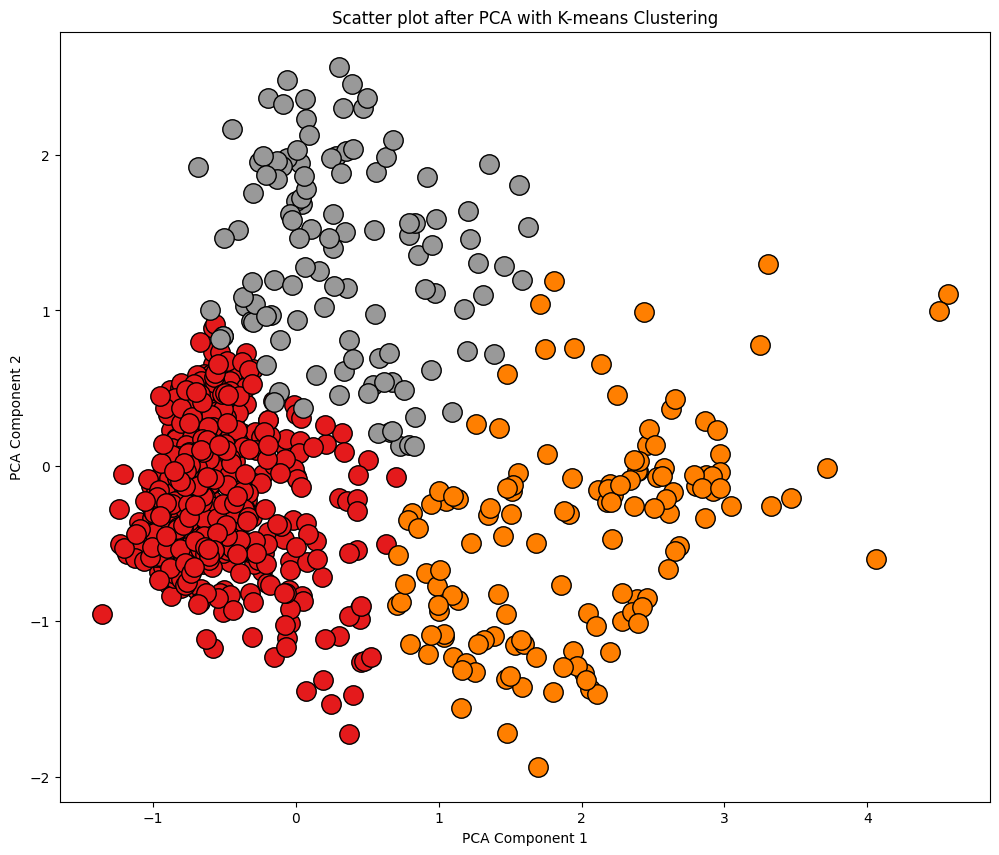

"plt.figure(figsize=(12, 10))\nunique_labels = set(cluster_labels) - {-1}  # Remove noise label\ncolors = [plt.cm.Set1(each) for each in np.linspace(0, 1, len(unique_labels))]\n\nfor k, col in zip(unique_labels, colors):\n    class_member_mask = (cluster_labels == k)\n    xy = PCA_result[class_member_mask]\n    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)\n\nplt.title('Scatter plot after PCA with DBSCAN Clustering (Noise Omitted)')\nplt.xlabel('PCA Component 1')\nplt.ylabel('PCA Component 2')\nplt.show()"

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

pca = PCA(n_components=10)
PCA_result = pca.fit_transform(embeddings)
print(PCA_result.shape)

# Perform DBSCAN clustering on node embeddings
# cluster_labels = dbscan(PCA_result,eps=1.0,MinPts=2) # Adjust eps and min_samples

"""pos = nx.spring_layout(G, seed=42, k=0.9)

# Visualize clusters
plt.figure(figsize=(12, 10))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=700, node_color=cluster_labels, cmap=plt.cm.Set1, edge_color='gray', alpha=0.6)
plt.title('Graph Clustering using DBSCAN')
plt.show()"""

k=3
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(PCA_result)

# Visualize the clusters with a scatter plot
plt.figure(figsize=(12, 10))
colors = [plt.cm.Set1(each) for each in np.linspace(0, 1, k)]

for label, col in zip(range(k), colors):
    class_member_mask = (cluster_labels == label)
    xy = PCA_result[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

plt.title('Scatter plot after PCA with K-means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.savefig('node2vec.png')
plt.show()

# Apply DBSCAN clustering to the PCA results
# cluster_labels = DBSCAN(eps=1.0, min_samples=2).fit_predict(PCA_result)

"""plt.figure(figsize=(12, 10))
unique_labels = set(cluster_labels) - {-1}  # Remove noise label
colors = [plt.cm.Set1(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (cluster_labels == k)
    xy = PCA_result[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

plt.title('Scatter plot after PCA with DBSCAN Clustering (Noise Omitted)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()"""